<a href="https://colab.research.google.com/github/jumbokh/ML-Class/blob/main/notebooks/4_6_%E6%A8%A1%E5%9E%8B%E5%8F%83%E6%95%B8%E6%8C%91%E9%81%B8%E5%92%8C%E7%B6%B2%E6%A0%BC%E6%90%9C%E5%B0%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在上一章我們做了各種機器學習的大亂鬥，但事實上，我們都還沒有談到如何去修改機器的預設參數。因此如果要比較各種機器學習的結果優劣，我們還必須考量不同參數的影響。你可以預想這個過程會變的相當複雜，因為針對每一個參數的組合我們都必須進行所謂的交叉驗證。如此一來程式會有多個迴圈，會耗費許多時間在執行也容易出錯。還好sklearn提供了網格搜尋的方式幫助我們解決這個問題。

到目前為止，讀者應該可以發現即使我們沒有刻意去調整參數，機器學習的預測參數都能提供相當不錯的預測結果。只不過透過參數的挑選，我們還有機會更進一步提升預測的正確率。

本章先用鳶尾花資料來做解釋，主要是因為它能繪出預測邊界便於我們了解這些參數如何作用在機器學習演算法上。

## 1 了解模型參數對預測結果的影響
範例： 定義邊界繪製函數  
這次的邊界繪製函數有略加修改，主要加了ax的參數為了能在不同的子圖呈現

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['DFKai-sb'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

def plot_decision_boundary(X_test, y_test, model, ax):
    points = 500
    x1_max, x2_max = X_test.max()
    x1_min, x2_min = X_test.min()
    X1, X2 = np.meshgrid(np.linspace(x1_min-0.1, x1_max+0.1, points),
                        np.linspace(x2_min-0.1, x2_max+0.1, points))
    x1_label, x2_label = X_test.columns
    X_test.plot(kind='scatter', x=x1_label, y=x2_label, c=y_test, cmap='coolwarm', 
                colorbar=False, s=20, ax=ax)
    grids = np.array(list(zip(X1.ravel(), X2.ravel())))
    ax.contourf(X1, X2, model.predict(grids).reshape(X1.shape), alpha=0.3,
               cmap='coolwarm')

範例： 載入鳶尾花的資料和完成資料預處理

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df = df[['sepal width (cm)', 'petal length (cm)']]
df['target'] = iris['target']
df = df.iloc[50:]
X_cols = df.columns.drop('target')
y_col = 'target'
X = df[X_cols]
y = df[y_col]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.33, random_state=42)

範例： 用預測邊界方式了解不同參數C對支持向量機的影響   
本章僅實驗支持向量機，其餘機器學習模型留可讀者自行學習。我們在支持向量機那一章有提到，其演算法有一個參數C可以調整選擇。C參數可以想像是對「錯誤分類」的懲罰參數，當C愈大時，支持向量機愈不允許錯誤，因此模型複雜度會提升，容易有過度擬合的情況發生。觀察下圖，你會發現C愈大時，邊界的彎曲程度也愈大。而當C愈小時對犯錯的懲罰就愈小，即犯錯允許程度。當小到一定程度時，任何的犯錯都是被許可的。因此就沒有任何的預測邊界，如下圖的C=0.001的情況。

小結：C大時，模型預測能力變複雜，但容易過度擬合。C小時，模型預測能力變弱，但預測的一般性會較高。

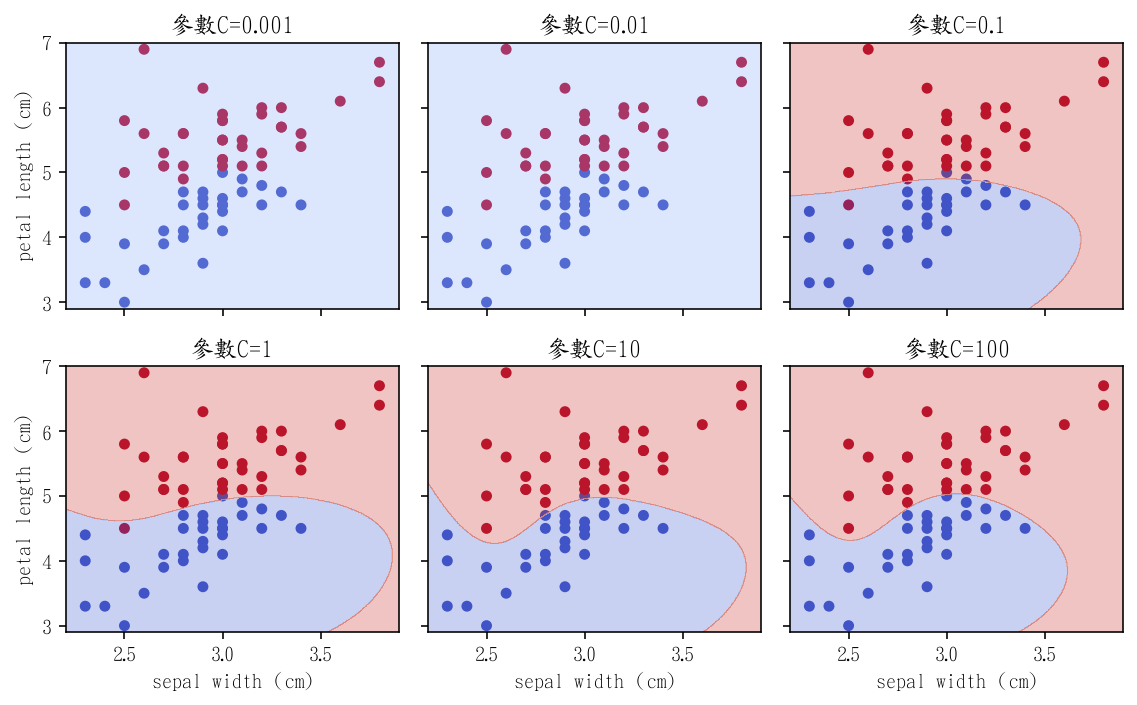

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
fig, axes = plt.subplots(2,3, figsize=(8,5), sharex=True, sharey=True)
scores = []
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for ax, c in zip(axes.ravel(), Cs):
    model_pl = make_pipeline(StandardScaler(), SVC(C=c))
    model_pl.fit(X_train, y_train)
    plot_decision_boundary(X_train, y_train, model_pl, ax)
    ax.set_title(f'參數C={c}')
plt.tight_layout()

範例： 用邊界繪圖方式了解gamma參數對支持向量機的影響  
支持向量機的預設kernel是rbf，它能將無法線性分割的資料投射到高的維度來進行分割，它有一個參數是gamma，當gamma愈大時，模型複雜程度會上升，容易有過度擬合的問題產生。觀察發現，gamma為0.001時，模型沒有預測能力。當gamma為0.01時相當於一條直線的分割。當gamma等於100時已產生過度擬合的情形。

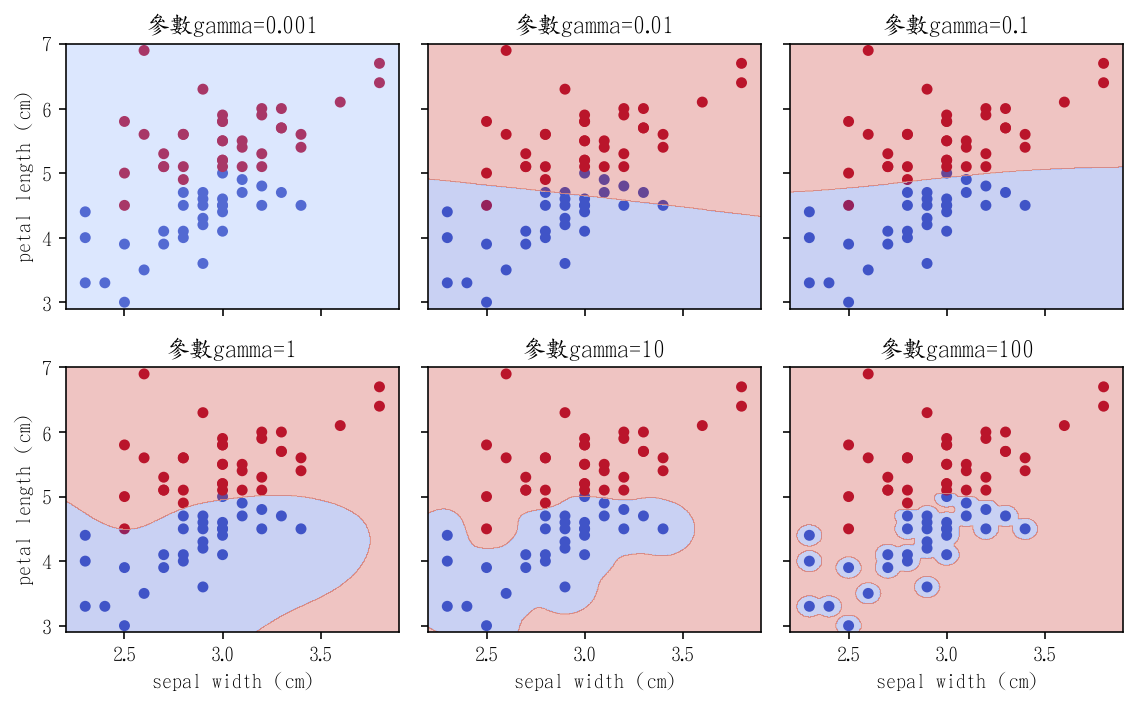

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(8,5), sharex=True, sharey=True)
scores = []
gammas = [0.001, 0.01, 0.1, 1, 10, 100]
for ax, gamma in zip(axes.ravel(), gammas):
    model_pl = make_pipeline(StandardScaler(), SVC(gamma=gamma))
    model_pl.fit(X_train, y_train)
    plot_decision_boundary(X_train, y_train, model_pl, ax)
    ax.set_title(f'參數gamma={gamma}')
plt.tight_layout()

## 2 網格搜尋參數設定
範例： 支持向量機能挑選的參數  
以支持向量機而言，我們要考量的參數有kernel的選擇，C的選擇，gamma的選擇。即使我們對這些值的意義有些了解，但如何挑選參數，仍要靠撰寫程式來挑出較佳的組合。這個自動化挑選參數的程式要做以下幾件事：
* 要用多個for迴圈進行所有參數組合
* 比較參數的好壞要用交叉驗證分析
* 最後要記錄不同參數的所有結果，再將最好的參數組合輸出

這一切光寫就「非常」麻煩，還好在model_selection模組裡的GridSearchCV能幫助我們達成上述的所有功能。這裡唯一要手動設定的是我們要實驗的參數組合。那要怎麼設定呢？關鍵就在於如何讓網格搜尋能夠去存取到管道器裡面的機器學習參數。

我們可以用get_params().keys()可看到管道器裡所有參數的索引鍵。網格搜尋就可以透過這個索引鍵去修改管道器裡面的值。

觀察發現索引鍵以svc開頭的就是用來設定支持向量機參數的索引鍵。換言之如果要設定支持向量機的kernel就要用'svc\__kernel'，要設定C的話就要用'svc\__C'，要設定gamma的話就用'svc\__gamma'。那字典索引鍵命名規則是什麼呢？以本例而言，由於管道器裡有轉換器和預測器，因此程式會自動設立成兩階段式的索引鍵：
* 第一階是預測器svc(SVC的小寫)
* 第二階svc裡的參數c或gamma  

這就是二階索引鍵的由來，先'svc'，再加「兩個」底線'\__'最後再加上你要的參數。再次強調，底線要兩個。以筆者教學經驗，很多人在這裡會犯錯。

如果你不想要去記憶索引鍵規則的話，最簡單的方法就是用get_params().keys()來觀察可以修改的索引鍵。

In [ ]:
model_pl = make_pipeline(StandardScaler(), SVC())
keys = model_pl.get_params().keys()
keys

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

範例： 支持向量機的參數組合偷懶版  
要使用網格搜尋前，要先知道如何將機器學習的參數包裝到字典格式。如支持向量機就要將參數kernel, C和gamma包在字典裡。不過，支持向量機的kernel只有是rbf時，才會同時需要C和gamma參數。如果kernel只是linear時，只要參數C。本例的寫法會讓程式做每種組合的嘗試，其中包括kernel是linear也會試不同gamma。雖然還是可以執行，但會比較浪費時間。  

In [ ]:
param_grid = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C':[0.1, 0.5, 0.8, 1, 5],
    'svc__gamma':np.arange(0.2, 1, 0.2)
}
print(param_grid)

{'svc__kernel': ['linear', 'rbf'], 'svc__C': [0.1, 0.5, 0.8, 1, 5], 'svc__gamma': array([0.2, 0.4, 0.6, 0.8])}


範例： 支持向量機的參數組合精確版  
精確的做法是用串列，將兩個不同kernel的參數分別用字典分別載入。格式上會比較複雜，因為最外層是串列，裡面才是參數的字典。不過這樣子就很清楚當kernel是linear時，只測試參數C的值。至於每個參數範圍的設定，通常需要一些實驗。在numpy裡的np.logspace()能幫助我們進行較大範圍的設定，有興趣讀者請自行研究。

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C':[0.1, 0.5, 0.8, 1, 5],
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C':[0.1, 0.5, 0.8, 1, 5],
        'svc__gamma':np.arange(0.2, 1, 0.2)
    }
]
print(param_grid)

[{'svc__kernel': ['linear'], 'svc__C': [0.1, 0.5, 0.8, 1, 5]}, {'svc__kernel': ['rbf'], 'svc__C': [0.1, 0.5, 0.8, 1, 5], 'svc__gamma': array([0.2, 0.4, 0.6, 0.8])}]


範例： 進行網格搜尋  
當預測管道器設定好，參數的實驗範圍也設定好後，就能拿出我們的終極武器GridSearchCV「網格搜尋」來幫我們找出最好的參數。網格，顧名思義就是網子上所有的格點，因此網格搜尋就是幫你將所有的參數組合都試過一遍，然後告訴你哪一個參數組合能得到最佳的預測結果。更甚者，你連不同模型，不同資料預處理的方式都能一起放進網格進行搜尋。  
網格搜尋的使用說明：
* 初使化網格搜尋物件：網格搜尋物件初始完後，就像是一般的「預測器」一樣。只不過初始化時有幾個重要參數，1. 你要搜尋的預測器，2. 網格的搜尋參數範圍，3. 交叉驗證的折數。至於return_train_score=True是為將整個搜尋結果的歷程都記錄下來。
* 初始化後，就像一般的預測器可用fit進行學習。觀察發現，你所設定的參數學習範圍會在param_grid變數裡

網格搜尋是如何判斷哪一個參數是最好的呢？它的作法是在訓練集裡用不同參數組合做交叉驗證，最後將交叉驗證結果的最好參數和結果儲存起來。

In [ ]:
model_pl = make_pipeline(StandardScaler(), SVC())
gs = GridSearchCV(model_pl, param_grid=param_grid, 
                  cv=10, return_train_score=True)
# 進行網格搜尋學習
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            

範例： 取得網格搜尋的最佳參數  
網格搜尋的最佳參數存放在best\_params\_屬性裡。kernel為線性，C為0.5，為交叉驗證結果
裡的最佳參數

In [ ]:
gs.best_params_

{'svc__C': 0.5, 'svc__kernel': 'linear'}

範例： 取得網格搜尋裡最佳預測的結果  
best\_score\_屬性裡可得到網格搜尋裡的最佳預測結果。在'svc\__C': 0.5, 'svc\__kernel': 'linear'的情況下，針對訓練集10折交叉驗證的最佳預測平均為0.97。

In [ ]:
gs.best_score_

0.9714285714285715

範例： 用交叉驗證來檢查上例結果的正確性  
訓練集10折交叉驗證的平均為0.971。與上例有些許誤差，應該是資料切割的亂數值所造成。

In [ ]:
from sklearn.model_selection import cross_val_score
model_pl_svc = make_pipeline(StandardScaler(), SVC(C=0.5, kernel='linear'))
scores = cross_val_score(model_pl_svc, X_train, y_train, cv=10)
print(f'十折交叉驗證的預測結果：{scores.round(3)}')
print(f'十折交叉驗證結果的平均值{scores.mean().round(3)}')

十折交叉驗證的預測結果：[1.    1.    0.714 1.    1.    1.    1.    1.    1.    1.   ]
十折交叉驗證結果的平均值0.971


範例： 最佳參數運用在測試集的預測結果    
目前得到的最佳參數和最佳預測結果都是針對訓練集的資料，那針對測試集的預測結果又是如何呢？觀察發現，結果僅有0.88，下降還蠻多的。探究原因應該是鳶尾花的樣本數太少導致結果的差異。以上例結果來看，雖然整體的正確率高達0.97，但其中的某一折正確率也只有0.71。

In [ ]:
model_pl_svc = make_pipeline(StandardScaler(), SVC(C=0.5, kernel='linear'))
model_pl_svc.fit(X_train, y_train)
model_pl_svc.score(X_test, y_test)

0.8787878787878788

範例： 取出網格搜尋裡，最佳參數的預測模型  
事實上，網格搜尋裡就有儲存最佳參數的預測模型在best\_estimator\_的屬性裡，它已經是依照最佳參數訓練好的預測器。觀察發現，C為0.5，kernel為linear，確實為最佳參數。因為best\_estimator\_已經是預測器，所以不用再重新學習可以直接使用。

In [ ]:
from sklearn.metrics import confusion_matrix
score = gs.best_estimator_.score(X_test, y_test)
y_pred = gs.best_estimator_.predict(X_test)
print(f'正確率為{score.round(3)}')
print(f'混亂矩陣結果為\n{confusion_matrix(y_test, y_pred)}')

正確率為0.879
混亂矩陣結果為
[[17  2]
 [ 2 12]]


範例： 跟預設參數的支持向量機比較  
預設參數的正確率是0.848，網格搜尋的預測結果為0.878，正確率確實是有往上提升。

In [ ]:
model_pl_svc = make_pipeline(StandardScaler(), SVC())
model_pl_svc.fit(X_train, y_train)
print(f'支持向量機的正確率：{model_pl_svc.score(X_test, y_test).round(3)}')

支持向量機的正確率：0.848


## 3 網格搜尋的過程分析
範例： 網格搜尋的過程分析  
有時候我們會想更進一步了解究竟參數是如何影響預測結果好壞，這時就要在GridSearchCV裡將參數return\_train\_score設為True。在cv\_results_裡存放著交叉驗證的所有分析結果，其中'mean\_test\_score'索引鍵提供了網格搜尋裡的交叉驗證的平均結果，而其對應的參數值則存放在'params'欄位。

因此我們先將gs.cv\_results_轉換成DataFrame的格式，再進一步取出['params','mean_test_score']欄位，最後用sort\_values依'mean\_test\_score'的值由大到小排序。我們列出前五筆最佳的參數值。觀察發現一個有趣的事實，原來同時有數筆資料在網格搜尋裡的交叉驗證結果是相同的，都是0.97。換言之，除了原本的最佳參數外，這些參數組合都是值得進一步探索的。

In [ ]:
# 第一行是為了能看欄位裡所有的值
pd.set_option('display.max_colwidth', -1) 
df_cv = pd.DataFrame(gs.cv_results_)[['params','mean_test_score']].\
sort_values(by = 'mean_test_score', ascending=False).head(12)
df_cv

,params,mean_test_score
12,"{'svc__C': 0.5, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}",0.971429
14,"{'svc__C': 0.8, 'svc__gamma': 0.4, 'svc__kernel': 'rbf'}",0.971429
2,"{'svc__C': 0.8, 'svc__kernel': 'linear'}",0.971429
3,"{'svc__C': 1, 'svc__kernel': 'linear'}",0.971429
22,"{'svc__C': 5, 'svc__gamma': 0.4, 'svc__kernel': 'rbf'}",0.971429
21,"{'svc__C': 5, 'svc__gamma': 0.2, 'svc__kernel': 'rbf'}",0.971429
20,"{'svc__C': 1, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}",0.971429
19,"{'svc__C': 1, 'svc__gamma': 0.6000000000000001, 'svc__kernel': 'rbf'}",0.971429
18,"{'svc__C': 1, 'svc__gamma': 0.4, 'svc__kernel': 'rbf'}",0.971429
16,"{'svc__C': 0.8, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}",0.971429


範例： 如何將上例的參數值送入管道器  
觀察上例知道第一筆參數{'svc\__C': 0.5, 'svc\__gamma': 0.8, 'svc\__kernel': 'rbf'}能得到一樣好的結果。那要如何將這組參數值放入管道器裡呢？可以用set_params的方法將參數值輸入。其中最簡單將參數送入的方法是用\*\*將字典的值直接送入函數。觀察模型的參數設定，C值已改成0.5，gamma是0.8。而在這組參數下，預測結果是0.85。

In [ ]:
model_pl_svc = make_pipeline(StandardScaler(), SVC())
param = {'svc__C': 0.5, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}
model_pl_svc.set_params(**param)
print(f"觀察模型的參數設定：{model_pl_svc.get_params()['svc']}")
model_pl_svc.fit(X_train, y_train)
print('正確率為:',model_pl_svc.score(X_test, y_test).round(3))

觀察模型的參數設定：SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.8, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
正確率為: 0.848


範例： 將DataFrame的params欄位來進行測試集預測  
上例只是一筆資料的練習，要如何將整個DataFrame裡的'params'一起用測試集算出預測結果呢？我們先寫一個函數能依不同參數算出測試集的預測結果。再用apply的方法將整個欄位算出。觀察發現最後一筆就是C為0.5，kernel為linear，測試集最高的正確率為0.878。

In [ ]:
def predict(param):
    model_pl_svc = make_pipeline(StandardScaler(), SVC())
    model_pl_svc.set_params(**param)
    model_pl_svc.fit(X_train, y_train)
    return model_pl_svc.score(X_test, y_test)
df_cv['accuracy'] = df_cv['params'].apply(predict)
df_cv

,params,mean_test_score,accuracy
12,"{'svc__C': 0.5, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}",0.971429,0.848485
14,"{'svc__C': 0.8, 'svc__gamma': 0.4, 'svc__kernel': 'rbf'}",0.971429,0.848485
2,"{'svc__C': 0.8, 'svc__kernel': 'linear'}",0.971429,0.848485
3,"{'svc__C': 1, 'svc__kernel': 'linear'}",0.971429,0.848485
22,"{'svc__C': 5, 'svc__gamma': 0.4, 'svc__kernel': 'rbf'}",0.971429,0.818182
21,"{'svc__C': 5, 'svc__gamma': 0.2, 'svc__kernel': 'rbf'}",0.971429,0.848485
20,"{'svc__C': 1, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}",0.971429,0.848485
19,"{'svc__C': 1, 'svc__gamma': 0.6000000000000001, 'svc__kernel': 'rbf'}",0.971429,0.848485
18,"{'svc__C': 1, 'svc__gamma': 0.4, 'svc__kernel': 'rbf'}",0.971429,0.848485
16,"{'svc__C': 0.8, 'svc__gamma': 0.8, 'svc__kernel': 'rbf'}",0.971429,0.848485


## 4 所有模型和其最佳參數一起比較  
到目前為止，我們完成了支持向量機的最佳參數挑選。接下來我們野心更大，想將所有的預測模型和其最佳參數都挑選出來。簡單的想法是寫一個大的for迴圈來執行不同的機器學習模型，並用網格搜尋得到最佳的預測模型和參數。接下來為了增加正確率的差異，我們用鳶尾花的全部欄位來學習，但仍是用50筆之後資料。  
範例： 鳶尾花的全部欄位載入

In [ ]:
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df['target'] = iris['target']
df = df.iloc[50:]
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.33, random_state=42)

範例： 不同模型的最佳參數比較  
第一步：將不同的機器學習模型，用串列存放到models的串列變數裡  
第二步：將不同機器學習的搜尋參數各自存放到不同的變數，再用串列整合到params變數裡  
第三步：用zip()將models和params結合在一起進入for迴圈來做網格搜尋  

變數命名：train_score為訓練集的交叉驗證結果，test_score為測試集的預測結果。觀察發現，在網格搜尋裡，結果最好的模型結果是支持向量機，其次是k最近鄰和羅吉斯迴歸。測試集預測的結果(test_score)，最好的仍是支持向量機0.94。

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = [LogisticRegression(), SVC(), 
          KNeighborsClassifier(), DecisionTreeClassifier()]
param_lr = {'logisticregression__penalty': ['l1', 'l2'],
            'logisticregression__C':[0.001,0.01,1,5,10]}
param_svc = {
    'svc__kernel':['linear','rbf'],
    'svc__C': [0.1, 0.5, 0.8, 1, 5],
    'svc__gamma': np.arange(0.2, 1, 0.2)
}
param_knn = {'kneighborsclassifier__n_neighbors':[5,10,15,20,25]}
param_tree = {'decisiontreeclassifier__min_samples_split':[5, 10, 15, 20, 30]}
params = [param_lr, param_svc, param_knn, param_tree]
scores = {}
for model, param in list(zip(models, params)):
    print(f'Model {model.__class__.__name__} 正在進行學習和預測...')
    model_pl = make_pipeline(StandardScaler(), model)
    gs = GridSearchCV(model_pl, param_grid=param, cv=5)
    gs.fit(X_train, y_train)
    score = gs.best_estimator_.score(X_test, y_test)
    data = {
        'train_score': gs.best_score_,
        'param': gs.best_params_,
        'test_score': score
    }
    scores[model.__class__.__name__] = data
df_gs_results = pd.DataFrame(scores, index=['train_score', 'test_score']).T
df_gs_results

Model LogisticRegression 正在進行學習和預測...
Model SVC 正在進行學習和預測...
Model KNeighborsClassifier 正在進行學習和預測...
Model DecisionTreeClassifier 正在進行學習和預測...


,train_score,test_score
LogisticRegression,0.971429,0.909091
SVC,1.000000,0.939394
KNeighborsClassifier,0.985714,0.909091
DecisionTreeClassifier,0.941758,0.818182


範例： 承上例將結果依照train_score高低排來排序  
排序過後的結果能更清楚看見哪個結果是最佳。

In [ ]:
df_gs_results.sort_values(by='train_score', ascending=False)

,train_score,test_score
SVC,1.000000,0.939394
KNeighborsClassifier,0.985714,0.909091
LogisticRegression,0.971429,0.909091
DecisionTreeClassifier,0.941758,0.818182


範例： 將不同模型與放入網格搜尋裡  
上例的寫法很清楚，但接下來要教大家的方法可是很少人知道的。我們要將模型也放入網格搜尋。如此一來連for迴圈都可以不用寫。    
首先，我們改用Pipeline來製作管道器，與make_pipeline唯一的差異是make_pipeline會自動幫我們加索引鍵，Pipeline則要自己設定索引鍵。由於我要將管道器裡的預測器置換，我想用一個一般性的名字如model，而不是像svc，因此選用Pipeline。  
Pipeline的使用也很簡單，參數裡的第一個參數是用串列傳入，串列裡面用tuple將索引鍵和轉換器或預測器連結起來。以本例而言，我將資料預處理的索引鍵設為preprocess，而將模型的索引鍵設為model。這樣子的命名比較一般化，你仍然可以用make_pipeline來完成這些工作。  
再來我們就將，模型和其參數一筆一筆用字典的格式描述清楚，在放入串列變數param_grid裡。你會發現所有的模型都用model索引鍵，這樣子比較一般化。接下來的步驟就跟原本是一樣的，通通交給網格搜尋來處理。

觀察發現與上例是相同的，svc仍是最佳的，參數也是相同的。不過相較於前例的結果，這個方法顯然比較簡單。

In [ ]:
from sklearn.pipeline import Pipeline
model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression())
])

param_grid = [
    {'model':[LogisticRegression()], 'model__penalty': ['l1', 'l2'], 
     'model__C':[0.001,0.01,1,5,10]},
    {'model':[SVC()], 'model__kernel':['linear','rbf'], 
     'model__C': [0.1, 0.5, 0.8, 1, 5],'model__gamma': np.arange(0.2, 1, 0.2)},
    {'model':[KNeighborsClassifier()], 'model__n_neighbors':[5,10,15,20,25]},
    {'model':[DecisionTreeClassifier()], 'model__min_samples_split':[5, 10, 15, 20, 30]}
]

gs = GridSearchCV(model_pl, param_grid=param_grid, 
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳預測模型和參數', gs.best_params_['model'])
print('訓練集的最佳結果', gs.best_score_)
print('測試集的預測結果', score)

最佳預測模型和參數 SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
訓練集的最佳結果 1.0
測試集的預測結果 0.9393939393939394


範例：  將資料預處理也放到網格搜尋裡  
為了執行速度考量，我們就選用三個資料預處理方式，StandardScaler，MinMaxScaler和不做任何處理。而預測器僅用支持向量機來做說明。觀察發現，最好的資料預處理是StandardScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression())
])
preprocess = [StandardScaler(), MinMaxScaler(), None]
param_grid = [
    {'preprocess': preprocess,
     'model':[SVC()], 'model__kernel':['linear','rbf'], 
     'model__C': [0.1, 0.5, 0.8, 1, 5],'model__gamma': np.arange(0.2, 1, 0.2)},
]
gs = GridSearchCV(model_pl, param_grid=param_grid, 
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳預處理方式', gs.best_params_['preprocess'])
print('訓練集交叉驗證的最佳結果', gs.best_score_)
print('測試集的預測結果', score)

最佳預處理方式 StandardScaler(copy=True, with_mean=True, with_std=True)
訓練集交叉驗證的最佳結果 1.0
測試集的預測結果 0.9393939393939394


## 5 威斯康辛大學的乳癌腫瘤資料  
接下來我們用之前的乳癌腫瘤資料進行預測和比較。  
範例： 模型綜合比較，採10折交叉驗證  
最佳的是支持向量機，kernel為rbf，C是1000，gamma=0.001。測試集預測結果為0.968。

In [ ]:
# 載入資料和資料預處理
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
X, y = breast_cancer['data'], breast_cancer['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.33, random_state=2)

model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression())
])
param_grid = [
    {'model':[LogisticRegression()], 'model__penalty': ['l1', 'l2'], 
     'model__C':[0.001,0.01,1,5,10]},
    {'model':[SVC()], 'model__kernel':['linear','rbf'], 
     'model__C': [0.1, 1, 10, 100, 1000],
     'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
    {'model':[KNeighborsClassifier()], 
     'model__n_neighbors':[5,10,15,20,25]},
    {'model':[DecisionTreeClassifier()], 
     'model__min_samples_split':[5, 10, 15, 20, 30]}
]
gs = GridSearchCV(model_pl, param_grid=param_grid,
                  cv=10, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳模型', gs.best_params_['model'])
print('最佳交叉驗證的結果', gs.best_score_)
print('最後測試集的結果', score)

最佳模型 SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
最佳交叉驗證的結果 0.9843454790823213
最後測試集的結果 0.9680851063829787


範例： 網格搜尋最佳的前十筆，並計算測試集結果  
用這個方法，我們能夠輸出的不僅是最佳的一筆網格搜尋資料，而是網格搜尋最佳的前10筆資料。這10筆資料都是值得我們進一步探索的。

In [ ]:
def predict(param):
    model_pl = Pipeline([
        ('preprocess', StandardScaler()),
        ('model', LogisticRegression())
    ])
    model_pl.set_params(**param)
    model_pl.fit(X_train, y_train)
    return model_pl.score(X_test, y_test)

df_cv = pd.DataFrame(gs.cv_results_)[['params','mean_test_score']].\
sort_values(by = 'mean_test_score', ascending=False)
df_cv_top10 = df_cv.iloc[:10]
# 模型名稱
df_cv_top10['model_name'] = df_cv_top10['params'].\
apply(lambda x: x['model'].__class__.__name__)
# 測試集正確率
df_cv_top10['accuracy'] = df_cv_top10['params'].\
apply(predict)
df_cv_top10 = df_cv_top10.set_index('model_name')[['mean_test_score','accuracy']]
df_cv_top10

,mean_test_score,accuracy
model_name,,
SVC,0.984345,0.968085
SVC,0.981781,0.968085
SVC,0.981781,0.968085
SVC,0.981781,0.968085
SVC,0.981781,0.968085
SVC,0.981781,0.968085
LogisticRegression,0.979150,0.973404
SVC,0.976518,0.984043
LogisticRegression,0.973887,0.957447


範例： 承上作圖  
藍色長條圖是網格搜尋裡交叉驗證的結果，其值是逐漸遞減。但有趣的是，橘色測試集的最好預測結果反而是落在最後一個預測模型。為什麼會這樣呢？這是因為在訓練集裡最佳的參數，未必是測試集理最佳的參數。只不過網格搜尋的方法是現階段最客觀的方式。

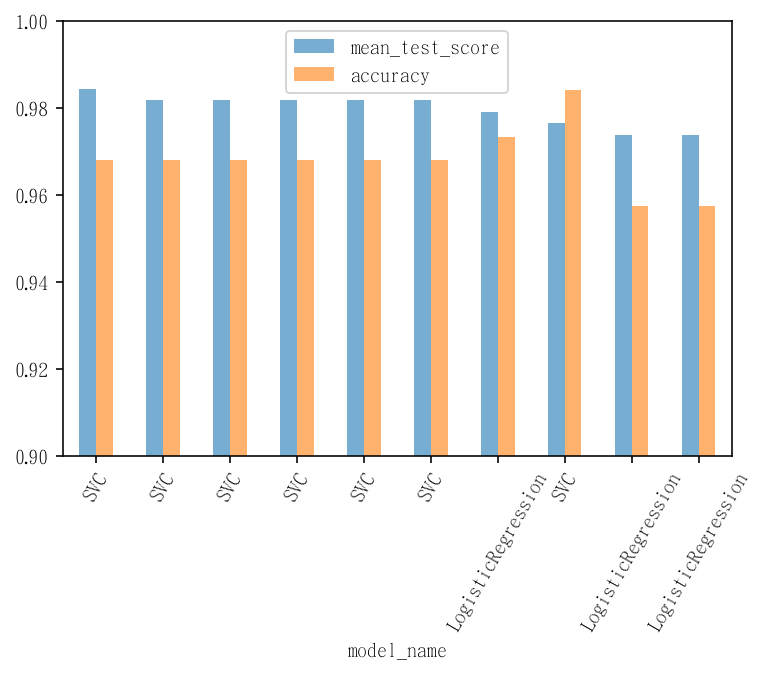

In [ ]:
df_cv_top10.plot(kind='bar',ylim=(0.9, 1), alpha=0.6, rot=60)

範例： 隨機網格搜尋  
當參數很多時網格搜尋會耗費很多時間，在model_selection裡有隨機網格搜尋的函數可以解決這個問題。但要特別注意的是其網格參數只能是字典格式，不能再用串列包字典。因此一次只能用一個機器學習方法來尋找最佳參數。以本例而言，原本要搜尋的網格點有(2 kernel)\*(10 C)\*(6 gamma)=120次，再加5折交叉驗證，要花很長的時間。這時你可以設定n_iter為20次，表示隨機抽出20個網格點來實驗，如此可以大幅縮短時間。通常我們可以先用隨機網格搜尋進行大範圍的探索，等範圍確定之後，再用一般的網格搜尋進行細部的參數探索。  
最佳預測參數是kernel為linear，C是2。測試集預測結果為0.968。

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression())
])
param_grid = {'model':[SVC()], 'model__kernel':['linear','rbf'], 
              'model__C': [0.1, 1, 2, 3, 4, 5, 6, 7, 10, 100],
              'model__gamma': [1, 0.1, 0.01, 0.001, 0.002, 0.0001]}
n_iter = 20
random_gs = RandomizedSearchCV(model_pl, param_distributions=param_grid,
                               n_iter=n_iter, cv=5, iid=False)
random_gs.fit(X_train, y_train)
score = random_gs.best_estimator_.score(X_test, y_test)
print('最佳模型', random_gs.best_params_['model'])
print('最佳交叉驗證的結果', random_gs.best_score_)
print('最後測試集的結果', score)

最佳模型 SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
最佳交叉驗證的結果 0.9816814764183185
最後測試集的結果 0.9680851063829787


## 作業

1. 用載入鳶尾花的資料，並只用['sepal width (cm)', 'petal length (cm)']和第50筆之後資料，請繪製k最近鄰的鄰居個數(從1到6)，並討論鄰居個數與模型預測的關係。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['DFKai-sb'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

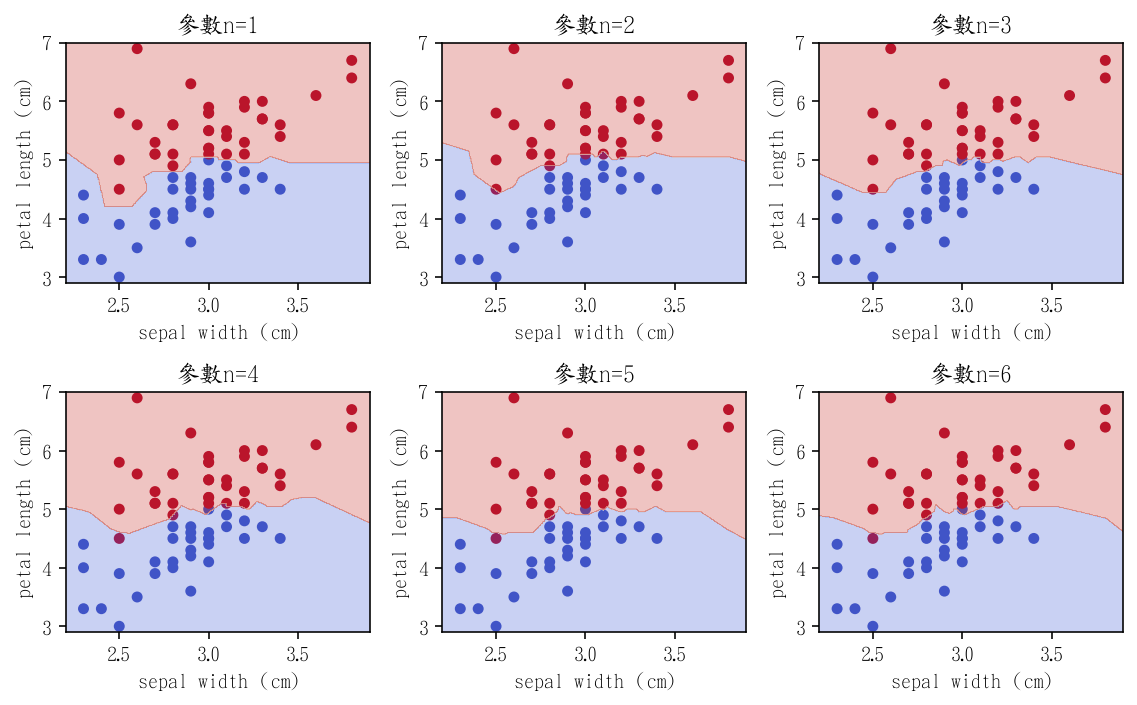

In [ ]:
def plot_decision_boundary(X_test, y_test, model, ax):
    points = 500
    x1_max, x2_max = X_test.max()
    x1_min, x2_min = X_test.min()
    X1, X2 = np.meshgrid(np.linspace(x1_min-0.1, x1_max+0.1, points),
                        np.linspace(x2_min-0.1, x2_max+0.1, points))
    x1_label, x2_label = X_test.columns
    X_test.plot(kind='scatter', x=x1_label, y=x2_label, c=y_test, cmap='coolwarm', 
                colorbar=False, s=20, ax=ax)
    grids = np.array(list(zip(X1.ravel(), X2.ravel())))
    ax.contourf(X1, X2, model.predict(grids).reshape(X1.shape), alpha=0.3,
               cmap='coolwarm')

from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df = df[['sepal width (cm)', 'petal length (cm)']]
df['target'] = iris['target']
df = df.iloc[50:]
X_cols = df.columns.drop('target')
y_col = 'target'
X = df[X_cols]
y = df[y_col]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.33, random_state=42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

fig, axes = plt.subplots(2,3, figsize=(8,5))
scores = []
ns = range(1, 7)
for ax, n in zip(axes.ravel(), ns):
    model_pl = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=n))
    model_pl.fit(X_train, y_train)
    plot_decision_boundary(X_train, y_train, model_pl, ax)
    ax.set_title(f'參數n={n}')
plt.tight_layout()

2. 用鐵達尼號的數據，來進行支持向量機的網格搜尋最佳參數。

In [ ]:
df = pd.read_csv('titanic_train.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.33, random_state=42)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

num_pl = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
cat_pl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder()
)

data_pl = ColumnTransformer([
    ('num_pl', num_pl, ['Age','Fare', 'SibSp','Parch','Pclass']),
    ('cat_pl', cat_pl, ['Sex','Embarked'])
])

model_pl = make_pipeline(data_pl, SVC())

param_grid = {'svc__kernel':['rbf'], 
              'svc__C': [0.1, 1, 10, 100],
              'svc__gamma': [1, 0.1, 0.01]}

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model_pl, param_grid=param_grid, 
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
y_pred = gs.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
print('最佳模型', gs.best_params_)
print('最佳交叉驗證的結果', gs.best_score_)
print('最後測試集的結果', accuracy_score(y_test, y_pred).round(2))
print(confusion_matrix(y_test, y_pred))

最佳模型 {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
最佳交叉驗證的結果 0.8154761904761904
最後測試集的結果 0.83
[[164  11]
 [ 40  80]]


3. 承上例，請算出前十筆最佳參數的預測結果。

In [ ]:
def predict(param):
    model_pl_svc = make_pipeline(data_pl, SVC())
    model_pl_svc.set_params(**param)
    model_pl_svc.fit(X_train, y_train)
    return model_pl_svc.score(X_test, y_test)

df_cv = pd.DataFrame(gs.cv_results_)[['params','mean_test_score']].\
sort_values(by = 'mean_test_score', ascending=False)

df_cv_top10 = df_cv.iloc[:10]
df_cv_top10

# 測試集正確率
df_cv_top10['accuracy'] = df_cv_top10['params'].apply(predict)
df_cv_top10 = df_cv_top10[['mean_test_score','accuracy']]
df_cv_top10

,mean_test_score,accuracy
7,0.815476,0.827119
4,0.807115,0.840678
11,0.807101,0.837288
8,0.797045,0.796610
3,0.796975,0.803390
5,0.790350,0.793220
1,0.788627,0.820339
10,0.786891,0.813559
6,0.783557,0.800000
9,0.758417,0.766102
